In [2]:
%load_ext autoreload
%autoreload 2

import json
import csv
import torch
from torch.utils.data import DataLoader, BufferedShuffleDataset
import sys
sys.path.append("utils/")
from datasets.AstDataset import AstDataset
from utils.TreeLstmUtils import batch_tree_input
from utils.TreePlotter import TreePlotter
from models.Vae import Vae
from loss_functions.TreeVaeLoss import TreeVaeLoss, TreeVaeLossComplete
from utils.TreeNode import Node
from anytree.exporter import JsonExporter
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
csv.field_size_limit(sys.maxsize)
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
# HYPERPARAMETERS
params = {
    'LEAF_EMBEDDING_DIM': 300,
    'EMBEDDING_DIM': 200,
    'HIDDEN_SIZE': 800,
    'LATENT_DIM': 800,
    'LEARNING_RATE': 1e-4,
    'EPOCHS': 30,
    'BATCH_SIZE': 64,
    'NUM_WORKERS': 8,
    'CLIP': 5,
    'KL_LOSS_WEIGHT': 0.001,
    'WEIGHTED_LOSS': False,         # Whether to weight the loss: with imbalanced vocabularies to how often the tokens occur
    'INDIV_LAYERS_VOCABS': False,   # Whether to use individual LSTM layers for each of the different vocabularies
    'TEACHER_FORCING_RATIO': 0.5,
}

def load_token_vocabulary(path):
    if os.path.isfile(path):
        # Load the reserved tokens dictionary
        with open(path, 'r') as json_f:
            json_data = json_f.read()

        # To JSON format (dictionary)
        tokens = json.loads(json_data)

    else:
        tokens = {}

        for dirpath, _, files in os.walk(path):
            for file in files:
                if file.endswith('.json'):
                    with open(os.path.join(dirpath, file), 'r') as json_f:
                        json_data = json_f.read()

                    # To JSON format (dictionary)
                    for k,v in json.loads(json_data).items():
                            if k in tokens:
                                tokens[k] += v
                            else:
                                tokens[k] = v

    return tokens


def train(dataset_path_train, dataset_path_val, tokens_paths=None, tokenized=False):
    token_vocabs = {}
    label_to_idx = None
    idx_to_label = None
    
    for k, path in tokens_paths.items():
        token_vocabs[k] = load_token_vocabulary(path)
        params[f'{k}_VOCAB_SIZE'] = len(token_vocabs[k])
        
        if params['WEIGHTED_LOSS']:
            loss_weights = 1 / torch.tensor(list(token_vocabs[k].values()))
            params[f'{k}_WEIGHTS'] = loss_weights / torch.sum(loss_weights) * len(token_vocabs[k]) * 1000
        else:
            params[f'{k}_WEIGHTS'] = torch.ones(len(token_vocabs[k]))
            
    
    if not tokenized:
        label_to_idx = {}
        idx_to_label = {}
        for k, vocab in token_vocabs.items():
            label_to_idx[k] = {k:i for i, k in enumerate(vocab.keys())}
            idx_to_label[k] = {v:k for k, v in label_to_idx[k].items()}
            
    non_res_tokens = len(tokens_paths) > 1
    
    weights_res = 1 / torch.tensor(list(token_vocabs['RES'].values()))
    params['WEIGHTS_RES'] = weights_res / torch.sum(weights_res) 
    
    train_dataset = AstDataset(dataset_path_train, label_to_idx, max_tree_size=750, remove_non_res=not non_res_tokens)
    train_dataset = BufferedShuffleDataset(train_dataset, buffer_size = 8)
    
    val_dataset = AstDataset(dataset_path_val, label_to_idx, max_tree_size=750, remove_non_res=not non_res_tokens)
    val_dataset = BufferedShuffleDataset(val_dataset, buffer_size = 8)

    train_loader = DataLoader(train_dataset, batch_size=params['BATCH_SIZE'], collate_fn=batch_tree_input, num_workers=params['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=params['BATCH_SIZE'], collate_fn=batch_tree_input, num_workers=params['NUM_WORKERS'])
    
    # set model
    vae = Vae(device, params)
        
    # Train
#     vae.train(loader, params['EPOCHS'], save_dir='checkpoints/')
    return vae, train_loader, val_loader, idx_to_label, label_to_idx, token_vocabs
    # Train
#     vae.train(loader, params['EPOCHS'])
    
tokens_paths = {
    'RES': '../data/ast_trees_full_22-04-2021/reserved_tokens/',
    'NAME': '../data/ast_trees_full_22-04-2021/name_tokens/',
    'TYPE': '../data/ast_trees_full_22-04-2021/type_tokens/',
    'LITERAL': '../data/ast_trees_full_22-04-2021/literal_tokens',
}
dataset_path_train = '../data/ast_trees_full_22-04-2021/asts/'
dataset_path_val = '../data/ast_trees_full_22-04-2021/asts/' #'../data/ast_trees_test/asts_val.csv.bz2'


vae, train_loader, val_loader, idx_to_label, label_to_idx, token_vocabs = train(dataset_path_train, dataset_path_val, tokens_paths)

In [26]:
with open(tokens_paths['RES'], 'r') as json_f:
    json_data = json_f.read()

# To JSON format (dictionary)
tokens = json.loads(json_data)
# tokens = dict(sorted(tokens.items(), key=lambda item: item[1]))

plt.figure(figsize=(30, 10))
plt.bar(range(len(tokens)), list(tokens.values()), align='center')
plt.xticks(range(len(tokens)), list(tokens.keys()), rotation=90)
plt.show()

IsADirectoryError: [Errno 21] Is a directory: '../data/ast_trees_full_22-04-2021/reserved_tokens/'

In [4]:
# tokens_paths = {
#     'RES': '../data/ast_trees_test/reserved_tokens.json',
#     'NAME': '../data/ast_trees_test/name_tokens.json',
#     'TYPE': '../data/ast_trees_test/type_tokens.json',
#     'LITERAL': '../data/ast_trees_test/literal_tokens.json',
# }

with open(tokens_paths['TYPE'], 'r') as json_f:
    json_data = json_f.read()

# To JSON format (dictionary)
tokens = json.loads(json_data)
tokens = dict(sorted(tokens.items(), key=lambda item: item[1], reverse=True))

# sum(list(tokens.values())[:100]) / sum(tokens.values())
tokens

{'int': 45222,
 'long long': 16330,
 'vector': 3382,
 'void': 2598,
 'pair': 1850,
 'bool': 1691,
 'auto': 1013,
 'char': 1012,
 'map': 773,
 'double': 625,
 'queue': 408,
 'unsigned int': 360,
 'unsigned long long': 351,
 'long double': 350,
 'long': 321,
 'set': 255,
 'priority_queue': 160,
 'unordered_map': 100,
 'unsigned long': 83,
 'multiset': 61,
 'short': 48,
 'bitset': 40,
 'string': 38,
 'shared_ptr': 35,
 'float': 26,
 'complex': 22,
 'deque': 21,
 'stack': 21,
 'array': 21,
 'tuple': 16,
 'unordered_set': 16,
 'T': 8,
 'istream_iterator': 6,
 'std::__cxx11::basic_string<char>': 5,
 'unsigned char': 3,
 'basic_string': 1}

In [45]:
tokens.update(tokens)

In [51]:
x = {'root': 0, 'y': 1, 'o': 2}
y = {'lol': 0, 'o': 1, 'p': 2, 'i': 3, 'y': 4}

for token in y.keys():
    if token not in x:
        x[token] = len(x)
        
x

{'root': 0, 'y': 1, 'o': 2, 'lol': 3, 'p': 4, 'i': 5}

In [13]:
(tokens['VAR_DECL'] + tokens['TYPE_KIND'] + tokens['TYPE'] + tokens['DECLARATOR'] + tokens['NAME'] + tokens['root']) / sum([v for k,v in tokens.items()])

0.3304729627684923

In [37]:
weights_for_samples = 1 / torch.tensor(list(tokens.values()))
weights_for_samples = weights_for_samples / torch.sum(weights_for_samples) 
sum(weights_for_samples)

tensor(1.0000)

In [32]:
weights_for_samples / torch.sum(weights_for_samples) * len(tokens)

tensor([7.2853e-03, 5.8509e-03, 7.1098e-03, 7.1098e-03, 2.8110e-04, 2.7580e-04,
        7.1098e-03, 4.3131e-04, 3.4046e-04, 1.4794e-04, 1.2284e-02, 1.6359e-03,
        3.0519e-04, 3.0356e-03, 4.8164e-04, 2.9735e-04, 3.6538e-04, 9.4756e-03,
        5.5746e-03, 8.9264e-05, 7.8133e-04, 1.8824e-03, 1.5770e-02, 2.4241e-03,
        3.6323e-03, 1.8798e-03, 1.3987e-03, 7.0342e-03, 3.2662e-03, 1.1955e-03,
        2.4791e-02, 1.0888e-02, 8.5184e-03, 7.4773e-03, 3.5451e-03, 2.4579e-03,
        2.0117e-03, 2.9732e-03, 7.1121e-03, 6.4792e-03, 1.2654e-02, 6.6569e-03,
        7.3614e-03, 2.5329e-03, 4.6500e-03, 2.0399e-03, 1.9856e+00, 5.2003e-01,
        3.2696e-03, 3.9016e-03, 3.9016e-03, 2.1001e-01, 8.8785e-02, 6.3191e-04,
        1.2154e-02, 2.3638e-03, 3.8184e-02, 1.5063e-01, 2.0186e-02, 4.1288e-02,
        6.0020e-03, 6.6186e-02, 9.7115e-03, 1.2340e-01, 8.7086e-03, 2.9436e-02,
        7.8453e-03, 5.2579e-03, 5.3611e-03, 4.5408e-02, 1.1844e-03, 3.1978e-02,
        2.6571e-02, 1.7614e-01, 2.0586e-

In [3]:
vae.load_model('checkpoints/800latent_800hidden/VAE_epoch29_23-04-2021_10:12.tar')

In [3]:
vae.train(epochs=2, train_loader=train_loader, val_loader=val_loader)

0batch [00:00, ?batch/s]

IndexError: Target 43 is out of bounds.

In [31]:
#train_dataset = AstDataset('../data/ast_trees_full_22-04-2021/asts/', label_to_idx, max_tree_size=-1, remove_non_res=False, get_statistics_only=True)
vocab = load_token_vocabulary('../data/ast_trees/reserved_tokens.json')
label_to_idx = {k:i for i, k in enumerate(vocab.keys())}
train_dataset = AstDataset('../data/ast_trees/asts/', label_to_idx, max_tree_size=-1, remove_non_res=False, get_statistics_only=True)
train_loader = DataLoader(train_dataset, batch_size=params['BATCH_SIZE'], num_workers=8)
tree_sizes = np.empty(0)
depths = np.empty(0)

for batch in tqdm(train_loader):
    tree_sizes = np.append(tree_sizes, batch[0])
    depths = np.append(depths, batch[1])

34it [00:06,  5.02it/s]


In [32]:
print(len(tree_sizes))
print(np.mean(tree_sizes))
print(np.median(tree_sizes))
print(np.min(tree_sizes))
print(np.max(tree_sizes))
print(np.quantile(tree_sizes, [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

print(len(depths))
print(np.mean(depths))
print(np.median(depths))
print(np.min(depths))
print(np.max(depths))
print(np.quantile(depths, [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

1995
519.9759398496241
418.0
19.0
2759.0
[ 155.94  198.    236.4   309.    418.    632.5   945.2  1208.6  1658.  ]
1995
15.934335839598997
16.0
7.0
34.0
[11. 12. 13. 14. 16. 18. 20. 21. 24.]


In [8]:
np.save('tree_sizes.npy', tree_sizes)
np.save('tree_depths.npy', depths)

## Plot for tree sizes CDF

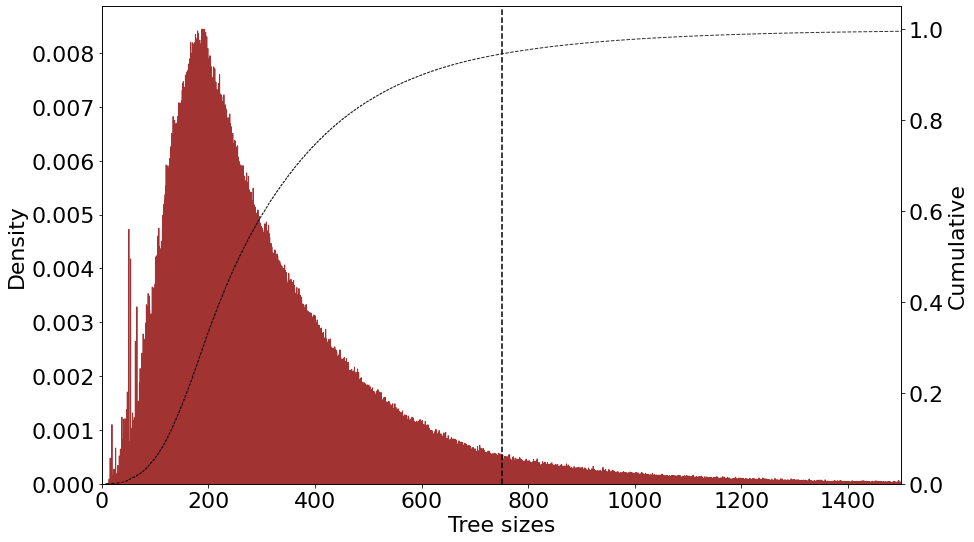

In [24]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})


tree_sizes = np.load('tree_sizes.npy')

fig, ax = plt.subplots(figsize=(14, 8))
ax.hist(tree_sizes, bins=100000, density=True, label='CDF',
         histtype='step', alpha=0.8, color='darkred')

plt.xlim([0, 1500])
# ax.set_ylim([0, 0.01])
ax.axvline(750, color='k', linestyle='--')

ax2 = ax.twinx()
ax2.hist(tree_sizes, bins=100000, density=True, cumulative=True, label='CDF',
         histtype='step', alpha=0.8, color='k', linestyle='dashed')
# plt.xlim([0, 2000])
ax.set_xlabel('Tree sizes')
ax.set_ylabel('Density')
ax2.set_ylabel('Cumulative')
plt.tight_layout()
plt.savefig('tree_sizes.png')
plt.show()

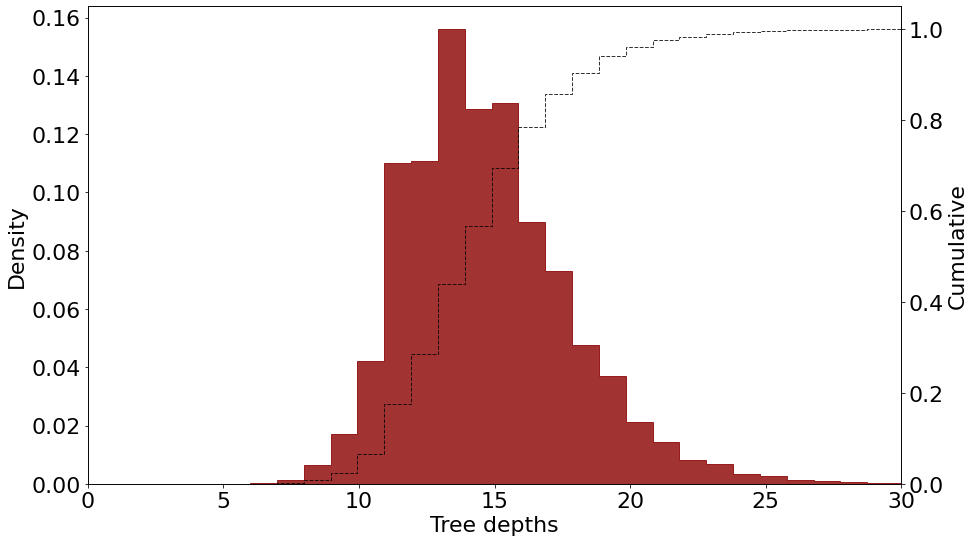

In [25]:
tree_depths = np.load('tree_depths.npy')

fig, ax = plt.subplots(figsize=(14, 8))
ax.hist(tree_depths, bins=467, density=True, label='CDF',
         histtype='step', alpha=0.8, color='darkred', fill=True)

plt.xlim([0, 30])
# ax.set_ylim([0, 0.01])
# ax.axvline(30, color='k', linestyle='--')

ax2 = ax.twinx()
ax2.hist(tree_depths, bins=467, density=True, cumulative=True, label='CDF',
         histtype='step', alpha=0.8, color='k', linestyle='dashed')
# plt.xlim([0, 2000])
ax.set_xlabel('Tree depths')
ax.set_ylabel('Density')
ax2.set_ylabel('Cumulative')
plt.tight_layout()
plt.savefig('tree_depths.png')
plt.show()

In [6]:
trees = vae.evaluate(data, idx_to_label['RES'])

exporter = JsonExporter()

df = pd.DataFrame(columns=['id', 'AST'])
for index, tree in enumerate(trees):
    ast = exporter.export(tree)
    df = df.append([{'id': index, 'AST' : ast}], ignore_index=True)
    
df.to_csv('output/asts.csv', index=False)

In [7]:
torch.rand(10)

tensor([0.0205, 0.7056, 0.7948, 0.0689, 0.2067, 0.2833, 0.1786, 0.4699, 0.0778,
        0.5171])

In [27]:
torch.cat([torch.empty(0), torch.tensor([[2, 3], [4, 5]])])

tensor([[2., 3.],
        [4., 5.]])

In [4]:
max_names = 0

for batch in tqdm(train_loader):
    max_names_batch = max([len(x) for x in batch['nameid_to_placeholderid']])
    if max_names_batch > max_names:
        max_names = max_names_batch
        print(max_names)
        

1it [00:03,  3.15s/it]

46


17it [00:05,  3.73it/s]

53


25it [00:07,  4.40it/s]

55


50it [00:13,  4.10it/s]

62


193it [00:38,  5.46it/s]

72


1272it [03:22,  5.96it/s]

74


1522it [04:02,  5.44it/s]

78


3516it [09:30,  7.40it/s]

79


4629it [12:19,  5.52it/s]

80


14072it [37:31,  6.90it/s]

84


16427it [43:30,  6.29it/s]


KeyboardInterrupt: 

71

In [51]:
tree = build_tree(data['adjacency_list'], data['features'])

In [32]:
exporter = JsonExporter()
exporter.export(tree)

'{"token": 0, "res": true, "children": [{"token": 2, "res": true, "children": [{"token": 3, "res": true, "children": [{"token": 0, "res": true}, {"token": 0, "res": true}]}, {"token": 4, "res": true, "children": [{"token": 2, "res": true}]}]}, {"token": 2, "res": true, "children": [{"token": 3, "res": true, "children": [{"token": 0, "res": true}, {"token": 0, "res": true}]}, {"token": 4, "res": true, "children": [{"token": 2, "res": true}]}]}, {"token": 2, "res": true, "children": [{"token": 3, "res": true, "children": [{"token": 0, "res": true}, {"token": 0, "res": true}]}, {"token": 4, "res": true, "children": [{"token": 2, "res": true}]}]}, {"token": 5, "res": true, "children": [{"token": 6, "res": true, "children": [{"token": 62, "res": true}]}, {"token": 7, "res": true, "children": [{"token": 8, "res": true, "children": [{"token": 11, "res": true}]}]}]}, {"token": 5, "res": true, "children": [{"token": 6, "res": true, "children": [{"token": 62, "res": true}, {"token": 14, "res": t

In [26]:
trees = pd.read_csv('../data/ast_trees_test/asts.csv.bz2')

In [27]:
for i in range(32):
    trees[int(len(trees) * i/32):int(len(trees) * (i + 1)/32)].to_csv(f'../data/ast_trees_test/asts/asts{i}.csv.bz2', index=False)
# trees[int(len(trees) * 0.8):].to_csv('../data/ast_trees_test/asts_val.csv.bz2', index=False)

In [52]:
torch.utils.data.random_split(range(10), [3, 7], torch.Generator())

In [65]:
print(trees.iloc[0][1])

{
  "token": "root",
  "res": true,
  "children": [
    {
      "token": "TYPEDEF_DECL",
      "res": true,
      "children": [
        {
          "token": "TYPE_DEF",
          "res": true,
          "children": [
            {
              "token": "TYPE_KIND",
              "res": true,
              "children": [
                {
                  "token": "TYPE",
                  "res": true,
                  "children": [
                    {
                      "token": "long long",
                      "res": false
                    }
                  ]
                }
              ]
            }
          ]
        },
        {
          "token": "IDENTIFIER",
          "res": true,
          "children": [
            {
              "token": "ll",
              "res": false
            }
          ]
        }
      ]
    },
    {
      "token": "TYPEDEF_DECL",
      "res": true,
      "children": [
        {
          "token": "TYPE_DEF",
          "res": true

In [13]:
tokens_leafs

{'i': 31827347,
 'int': 25890376,
 'long': 18038509,
 '0': 16106854,
 '1': 15929649,
 'n': 13349673,
 'a': 10066010,
 'operator<<': 7562627,
 'x': 7226008,
 'j': 7035975,
 '<': 6431762,
 '>': 6197419,
 'operator[]': 6045917,
 'operator>>': 5497929,
 'b': 5326486,
 'll': 4508242,
 'cin': 4429537,
 'cout': 4421382,
 's': 4144000,
 'ans': 3963303,
 'k': 3961537,
 '[': 3909721,
 ']': 3909299,
 '2': 3870988,
 'm': 3452776,
 '::': 3439870,
 'v': 3242932,
 'std': 3214599,
 'y': 2859375,
 ',': 2716950,
 'c': 2622521,
 'main': 2611171,
 'vector': 2599643,
 'const': 2446546,
 'p': 2323290,
 'r': 2290901,
 'l': 2263686,
 't': 2011363,
 'T': 1685724,
 'pair': 1662798,
 'endl': 1448796,
 '&': 1401756,
 'void': 1390236,
 'N': 1385845,
 'u': 1379802,
 'size': 1325908,
 'cnt': 1296733,
 'string': 1228257,
 'scanf': 1212740,
 'd': 1210295,
 'sum': 1200130,
 'q': 1132427,
 'res': 1097368,
 'tie': 1092758,
 'f': 1074405,
 'double': 1060846,
 'printf': 1057509,
 'bool': 1032033,
 'push_back': 1015712,
 'f

In [99]:
label_dict = dict((reversed(item) for item in reserved_tokens.items()))

In [46]:
trees.to_hdf('asts.h5', key='asts', mode='w', complib='blosc')

In [27]:
print(exporter.export(tree))

{"token": 0, "res": true, "children": [{"token": 7, "res": true, "children": [{"token": 4, "res": true, "children": [{"token": 5, "res": true, "children": [{"token": 3, "res": false}]}]}, {"token": 8, "res": true, "children": [{"token": 9, "res": true, "children": [{"token": 11, "res": false}]}]}]}, {"token": 7, "res": true, "children": [{"token": 4, "res": true, "children": [{"token": 5, "res": true, "children": [{"token": 3, "res": false}]}]}, {"token": 8, "res": true, "children": [{"token": 9, "res": true, "children": [{"token": 11, "res": false}]}]}]}, {"token": 7, "res": true, "children": [{"token": 4, "res": true, "children": [{"token": 5, "res": true, "children": [{"token": 3, "res": false}]}]}, {"token": 8, "res": true, "children": [{"token": 9, "res": true, "children": [{"token": 11, "res": false}]}]}]}, {"token": 7, "res": true, "children": [{"token": 4, "res": true, "children": [{"token": 5, "res": true, "children": [{"token": 3, "res": false}]}]}, {"token": 8, "res": true, 

In [75]:
z = torch.tensor([np.random.normal(loc=0.0, scale=1.0, size=params['LATENT_DIM']) for i in range(5)], device=device).float()
z.shape

torch.Size([5, 256])

In [77]:
generated_trees = vae.generate(z)

In [84]:
TreePlotter.plot_predicted_tree(generated_trees[0], 'generated_tree.png')

In [9]:
for batch in loader:
    for key in batch.keys():
        if key != 'tree_sizes':
            batch[key] = batch[key].to(device)
            
    encoder.eval()
    decoder.eval()
    z, _, _ = encoder(batch)
    trees = decoder(z)
    break

In [41]:
idx_to_label = dict((reversed(item) for item in label_to_idx.items()))
idx_to_res_label = dict((reversed(item) for item in res_label_to_idx.items()))

In [108]:
with open('tokens.json', 'w') as f:
    f.write(json.dumps(label_to_idx))
    
with open('reserved_tokens.json', 'w') as f:
    f.write(json.dumps(res_label_to_idx))

In [2]:
trees = pd.read_csv('../data/ast_trees_test/asts.csv.bz2')
tree = trees.iloc[0][1]

In [18]:
print(trees[trees['id'] == 50794461]['AST'].iloc[0])

{
  "token": "root",
  "res": true,
  "children": [
    {
      "token": "FUNCTION_DECL",
      "res": true,
      "children": [
        {
          "token": "NAME",
          "res": true,
          "children": [
            {
              "token": "BFS",
              "res": false
            }
          ]
        },
        {
          "token": "TYPE_KIND",
          "res": true,
          "children": [
            {
              "token": "TYPE",
              "res": true,
              "children": [
                {
                  "token": "bool",
                  "res": false
                }
              ]
            }
          ]
        },
        {
          "token": "PARM_DECL",
          "res": true,
          "children": [
            {
              "token": "TYPE_KIND",
              "res": true,
              "children": [
                {
                  "token": "LVALUEREFERENCE",
                  "res": true,
                  "children": [
              

In [11]:
for tree in trees.iterrows():
    if 'UNEXPOSED_DECL' in tree[1]['AST']:
        print(tree[1]['id'])
#         print(tree[1]['AST'])

52626773
52628504
45879606
45874527
45786834
45706773
45179500
44611630
44611114
44611001
44610840
44609194
44609041
44607221
44592120
44591582
44591221
104465269
59131566


In [24]:
from anytree.importer import JsonImporter

In [16]:
JsonImporter().import_()

TypeError: import_() takes 2 positional arguments but 3 were given

In [32]:
TreePlotter.plot_tree(trees[0], 'first_tree.png', idx_to_label, idx_to_label['RES'])

In [4]:
TreePlotter.plot_tree(tree, 'actual_tree_tree.png')
# TreePlotter.plot_tree(tree, 'actual_tree.png', label_dict)

AttributeError: 'str' object has no attribute 'res'

In [70]:
from anytree.exporter import JsonExporter
exporter = JsonExporter()
with open('test.json', 'w') as f:
    f.write(exporter.export(trees[0]))

In [86]:
decoder.eval()
trees = decoder(z)

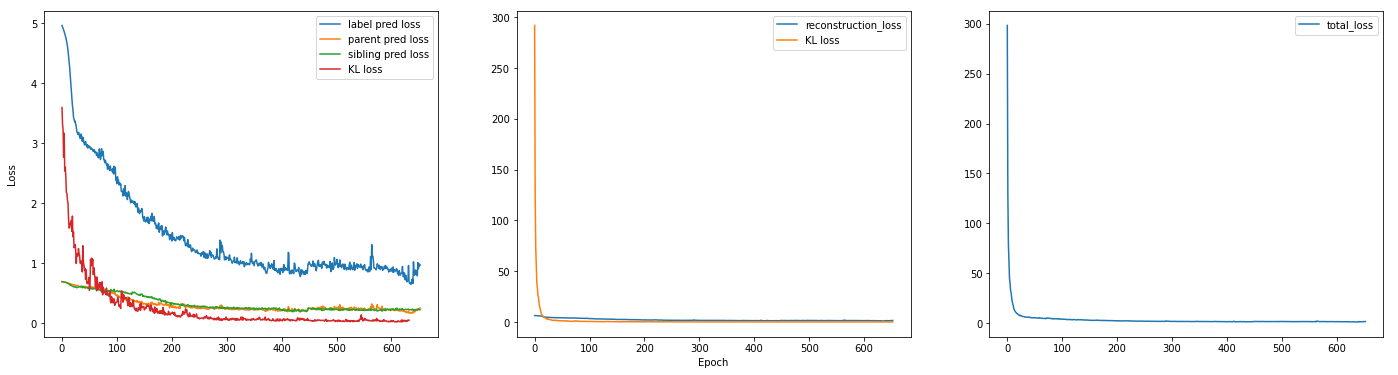

In [123]:
figure, ax = plt.subplots(1, 3, figsize=(24,6))
figure.add_subplot(111, frameon=False)

ax[0].plot(losses['label_prediction_loss'], label='label pred loss')
ax[0].plot(losses['parent_loss'], label='parent pred loss')
ax[0].plot(losses['sibling_loss'], label='sibling pred loss')
ax[0].plot(losses['kl_loss'][20:], label='KL loss')
ax[0].legend()

ax[1].plot(np.add(np.add(losses['label_prediction_loss'], losses['parent_loss']), losses['sibling_loss']), label='reconstruction_loss')
ax[1].plot(losses['kl_loss'], label='KL loss')
ax[1].legend()

ax[2].plot(losses['total_loss'], label='total_loss')
ax[2].legend()

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [150]:
parents = list(set([el.item() for el in batch['adjacency_list'][:169][:, 0]]))

In [49]:
def build_tree(adj_list, features, index=0, parent_node=None):
    node = Node(features[index].item(), parent=parent_node)
    children = adj_list[adj_list[:, 0] == index][:, 1]

    for child in children:
        build_tree(adj_list, features, child, node)

    return node
            

In [161]:
tree = build_tree(batch['adjacency_list'], batch['features'])

In [172]:
pred_tree = build_tree(batch['adjacency_list'], torch.argmax(output['predicted_labels'], dim=-1))

In [176]:
TreePlotter.plot_predicted_tree(pred_tree, 'predicted_tree.png')
TreePlotter.plot_predicted_tree(tree, 'actual_tree.png')

In [ ]:
TreePlotter.plot_predicted_tree(reconstructed_tree[0], 'predicted_tree.png')

In [7]:
reader = csv.reader(open('../data/ast_trees/asts.csv.bz2'))

next(reader)

TreePlotter.plot_tree(JsonImporter().import_(next(reader)[1]), 'first_tree.png')


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 10: invalid start byte